(getting-started:tutorial-reliability)=
# Tutorial: Test a Reliability Analysis Method

UQTestFuns includes several test functions from the literature employed
in a reliability analysis exercise.
In this tutorial, you'll implement a method to estimate the failure probability
of a computational model and test the implementation using a test function
available in UQTestFuns.

By the end of this tutorial, you'll get an idea how a function from UQTestFuns
is used to test a reliability analysis method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uqtestfuns as uqtf

## Reliability analysis

Consider a system whose performance is defined by a _performance function_[^lsf]
$g$ whose values, in turn, depend on:

- $\boldsymbol{x}_p$: the (uncertain) input variables
  of an underlying computational model $\mathcal{M}$
- $\boldsymbol{x}_s$: additional (uncertain) input variables that affects
  the performance of the system, but not part of inputs to $\mathcal{M}$ 
- $\boldsymbol{p}$: an additional set of _deterministic_ parameters of the system

Combining these variables and parameters as an input to the performance function $g$:

$$
g(\boldsymbol{x}; \boldsymbol{p}) = g(\mathcal{M}(\boldsymbol{x}_p), \boldsymbol{x}_s; \boldsymbol{p}),
$$

where $\boldsymbol{x} = \{ \boldsymbol{x}_p, \boldsymbol{x}_s \}$.

The system is said to be in _failure state_ if and only if
$g(\boldsymbol{x}; \boldsymbol{p}) \leq 0$;
the set of all values $\{ \boldsymbol{x}, \boldsymbol{p} \}$
such that $g(\boldsymbol{x}; \boldsymbol{p}) \leq 0$
is called the _failure domain_.

Conversely, the system is said to be in _safe state_
if and only if $g(\boldsymbol{x}; \boldsymbol{p}) > 0$;
the set of all values $\{ \boldsymbol{x}, \boldsymbol{p} \}$
such that $g(\boldsymbol{x}; \boldsymbol{p}) > 0$
is called the _safe domain_.

### Failure probability

_Reliability analysis_[^rare-event] concerns with estimating
the failure probability of a system with a given performance function $g$. 
For a given joint probability density function (PDF) $f_{\boldsymbol{X}}$
of the uncertain input variables $\boldsymbol{X} = \{ \boldsymbol{X}_p, \boldsymbol{X}_s \}$,
the failure probability $P_f$ of the system is defined
as follows {cite}`Sudret2012, Verma2015`:

$$
P_f \equiv \mathbb{P}[g(\boldsymbol{X}; \boldsymbol{p}) \leq 0] = \int_{\{ \boldsymbol{x} | g(\boldsymbol{x}; \boldsymbol{p}) \leq 0 \}} f_{\boldsymbol{X}} (\boldsymbol{x}) \, \; d\boldsymbol{x}.
$$

Evaluating the above integral is, in general, non-trivial because the domain
of integration is only provided implicitly and the number of dimensions may
be large.

### Monte-Carlo estimation

```{warning}
The Monte-Carlo method implemented below is one of the most straightforward
and robust approach to estimate (small) failure probability.
However, the method is rarely used for practical applications due to its
high computational cost.
It is used here in this tutorial simply as an illustration. 
Numerous methods have been developed to efficiently and accurately estimate
the failure probability of a computational model.
```

The failure probability of a computational model given probabilistic inputs
may be directly estimated using a Monte-Carlo simulation.
Such a method is straightforward to implement though potentially computationally
expensive as the chance of observing a failure event in a typical reliability
analysis problem is very small.

An alternative formulation of the failure probability following
{cite}`Beck2015` that aligns well with Monte-Carlo simulation is given below:

$$
Pf \equiv \mathbb{P}[g(\boldsymbol{X}; \boldsymbol{p}) \leq 0] = \int_{\mathcal{D}_{\boldsymbol{X}}} \mathbb{I}[g(\boldsymbol{x} \leq 0)] f_{\boldsymbol{X}} (\boldsymbol{x}) \, d\boldsymbol{x},
$$
where $\mathbb{I}[g(\boldsymbol{x}; \boldsymbol{p}) \leq 0]$ is the indicator function such that:

$$
\mathbb{I}[g(\boldsymbol{x}; \boldsymbol{p}) \leq 0] =
  \begin{cases}
    1, g(\boldsymbol{x}; \boldsymbol{p}) \leq 0 \\
    0, g(\boldsymbol{x}; \boldsymbol{p}) > 0. \\
  \end{cases}
$$

The Monte-Carlo estimate of the failure probability is given as follows:

$$
P_f \approx \widehat{P}_f = \frac{1}{N} \sum^N_{i = 1} \mathbb{I}[g(\boldsymbol{x}^{(i)} \leq 0],
$$
where $N$ is the number of Monte-Carlo sample points.

To assess the accuracy of the estimate given by the above equation, 
the coefficient of variation ($\mathrm{CoV}$) is often used:

$$
\mathrm{CoV}[\widehat{P}_f] \equiv \frac{\left( \mathbb{V}[\widehat{P}_f] \right)^{0.5}}{\mathbb{E}[\widehat{P}_f]} = \left( \frac{1 - \widehat{P}_f}{N \widehat{P}_f} \right)^{0.5},
$$

The Monte-Carlo simulation method to estimate the failure probability is 
summarized in {prf:ref}`MC Simulation Pf`.

```{prf:algorithm} Monte-Carlo simulation for estimating $P_f$
:label: MC Simulation Pf

**Inputs** A performance function $g$, random input variables $\boldsymbol{X}$, number of MC sample points $N$

**Output** $\widehat{P}_f$ and $\mathrm{CoV}[\widehat{P}_f]$

1. $N_f \leftarrow 0$
2. For $i = 1$ to $N$:

    1. Sample $\boldsymbol{x}^{(i)}$ from $\boldsymbol{X}$
    2. Evaluate $g(\boldsymbol{x}^{(i); \boldsymbol{p}})$
    3. If $g(\boldsymbol{x}^{(i)}; \boldsymbol{p}) \leq 0$:
      
        - $N_f \leftarrow N_f + 1$
 
 3. $\widehat{P}_f = \frac{N_f}{N}$
 4. $\mathrm{CoV}[\widehat{P}_f] = \left( \frac{1 - \widehat{P}_f}{N \widehat{P}_f} \right)^{0.5}$
```

{prf:ref}`MC Simulation Pf` is implemented in a Python function that assumes
the performance function can be evaluated in a vectorized manner
and a probabilistic model of the relevant inputs has been defined such that
sample points can be generated from them.

```{note}
And indeed, test functions included in UQTestFuns are all given with the
corresponding probabilistic input model according to the literature.
```

In [2]:
def estimate_pf(performance_function, prob_input, sample_size):
    """Estimate failure probability via MC simulation.
    
    Parameters
    ----------
    performance_function
      The function to be evaluated; accepts a vector of values as the input.
    prob_input
      The probabilistic input model of the performance function.
    sample_size
      The Monte-Carlo simulation sample size.
      
    Returns
    -------
    Tuple
      The estimated failure probability and its coefficient of variation (CoV).
    """

    xx = prob_input.get_sample(sample_size)
    yy = performance_function(xx)

    pf = np.sum(yy <= 0) / sample_size
    cov = np.sqrt((1 - pf) / (sample_size * pf))

    return pf, cov

## Two-dimensional cantilever beam reliability problem

To test the implemented algorithm above, we choose the two-dimensional 
cantilever beam reliability problem included in UQTestFuns. Several published
results are available for this problem.

The reliability problem consists of a cantilever beam with a rectangular
cross-section subjected to a uniformly distributed loading. 
The maximum deflection at the free end is taken to be the performance criterion
such that the performance function reads:

$$
g(\boldsymbol{x}; \boldsymbol{p}) = \frac{l}{325} - \frac{12 l^4 w}{8 E h^3},
$$
where $\boldsymbol{x} = \{ w, h \}$ is the two-dimensional vector of
input variables, namely the load per unit area ($w$)
and the depth of the cross section ($h$);
and $\boldsymbol{p} = \{ E l\}$ is the vector of parameters,
namely the modulus of elasticity of the beam ($E$) and the span of the beam
($l$).

To create an instance of the cantilever beam function:

In [3]:
cantilever = uqtf.CantileverBeam2D()

The input variables $w$ and $h$ are probabilistically defined according
to the table below.

In [4]:
cantilever.prob_input

ProbInput(spatial_dimension=2, marginals=(UnivDist(distribution='normal', parameters=array([1000.,  200.]), name='W', description='Load per unit area [N/m^2]'), UnivDist(distribution='normal', parameters=array([250. ,  37.5]), name='H', description='Depth of the cross-section [mm]')), copulas=None, name='Cantilever2D-Rajashekhar1993', description='Input model for the cantilever beam problem from Rajashekhar and Ellingwood (1993)')

The default values of the parameters $E$ and $l$ are:

In [5]:
cantilever.parameters

(26000.0, 6000.0)

For reproducibility of this tutorial, set the seed number of the 
pseudo-random generator attached to the probabilistic input model:

In [6]:
cantilever.prob_input.reset_rng(245634)

Finally, several published results of the failure probability of the problem
are as follows:

- $\widehat{P}_f = 9.88 \times 10^{-3}$ using {term}`FORM` with $27$ 
  performance function evaluations ({cite}`Li2018`)
- $\widehat{P}_f = 9.6071 \times 10^{-3}$ using {term}`IS` with $10^3$
  performance function evaluations ({cite}`Rajashekhar1993`)
- $\widehat{P}_f = 9.499 \times 10^{-3}$ using sequential surrogate reliability
  method with $18$ performance function evaluations ({cite}`Li2018`)

## Failure probability estimation

To observe the convergence of the estimation procedure implemented above,
several Monte-Carlo sample sizes are used:

In [7]:
sample_sizes = 5**np.arange(3, 12)
pf_estimates = np.zeros(len(sample_sizes))
cov_estimates = np.zeros(len(sample_sizes))

for i, sample_size in enumerate(sample_sizes):
    pf_estimates[i], cov_estimates[i] = estimate_pf(
        cantilever, cantilever.prob_input, sample_size
    )

The estimated failure probability as a function of sample size is plotted
below. The uncertainty band around the estimate is also included and it
corresponds to one standard deviation.

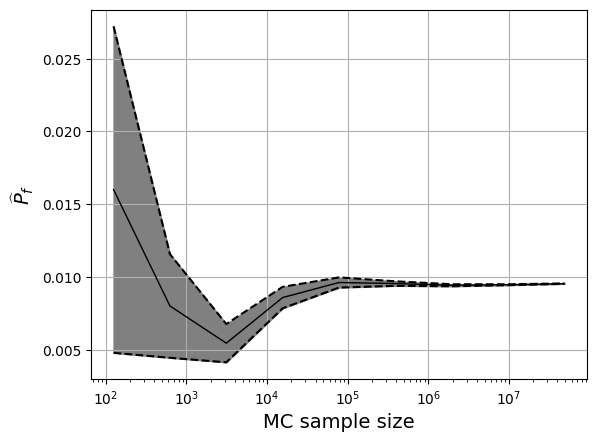

In [8]:
fig, ax = plt.subplots(1, 1)

ax.plot(sample_sizes, pf_estimates, color="k", linewidth=1.0)
ax.plot(
    sample_sizes, pf_estimates * (1 + cov_estimates), color="k", linestyle="--"
)
ax.plot(
    sample_sizes, pf_estimates * (1 - cov_estimates), color="k", linestyle="--"
)
ax.fill_between(
    sample_sizes,
    pf_estimates * (1 + cov_estimates),
    pf_estimates * (1 - cov_estimates),
    color="gray",
)
ax.grid()
ax.set_xscale("log")
ax.set_xlabel("MC sample size", fontsize=14)
ax.set_ylabel(r"$\widehat{P}_f$", fontsize=14);

The final estimate of the failure probability
(from $>10^7$ function evaluations) is:

In [9]:
print(f"{pf_estimates[-1]:1.4e}")

9.5340e-03


This values seems to be consistent with the provided published results
albeit with a much higher computational cost.

The challenge for a reliability analysis method is to accurately and 
efficiently (as few performance function evaluations as possible)
estimate the failure probability.

## References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```

[^lsf]: also called _limit-state function_

[^rare-event]: also called rare-events estimation